In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import squarify
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, norm, chi2_contingency
from statsmodels.stats.weightstats import ztest


from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
pd.options.display.max_rows = 10
pd.options.display.max_columns = 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions

In [17]:
def replace_labels(ax, char, axis='y'):
    # Customize y-labels
    if axis == 'x':
        _ = ticks_loc = ax.get_xticks().tolist()
        _ = ax.set_xticks(ticks_loc)
        _ = ax.set_xticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    if axis == 'y':
        _ = ticks_loc = ax.get_yticks().tolist()
        _ = ax.set_yticks(ticks_loc)
        _ = ax.set_yticklabels([f'{x:,.0f}{char}' for x in ticks_loc])
    
def perfom_anderson_test(data):
	result = anderson(data)
	print('Statistic = %.2f' % result.statistic)

	p = 0
	for i in range(len(result.critical_values)):
		sl, cv = result.significance_level[i], result.critical_values[i]
		if result.statistic < result.critical_values[i]:
			print(f'significance level = {sl:.2f}, critical value = {cv:.2f}, (fail to reject H0)')
		else:
			print(f'significance level = {sl:.2f}, critical value = {cv:.2f}, (reject H0)')
	print('\n')

def get_test_result(name, score, p_value, significance=0.05):
    # Test the p-value
    print(f"{name}")
    print(f"Score: {score:0.2f} and p-value: {p_value:0.2f}")
    if (p_value < significance):
        print(f'H0 can be rejected!')
    else:
        print('Fail to reject H0')

### Import dataset


In [18]:
df = pd.read_csv("../data/raw/train.csv")

### Explore data

This dataset has:

5 discrete numerical variables: *PassengerId, Survived, Pclass, SibSp, Parch*

2 numerical continuous variables: *Age, Fare*

5 categorical variables: *Name, Sex, Ticket, Cabin, Embarked*

In [19]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The data seems to haven't erroneous values, like negative *Age, Parch* or *Fare*

In [20]:
df.describe()

,PassengerId,Survived,Pclass,...,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,...,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,...,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,...,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,...,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,...,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,...,8.000000,6.000000,512.329200


In [21]:

df.head()

,PassengerId,Survived,Pclass,...,Fare,Cabin,Embarked
0,1,0,3,...,7.2500,NaN,S
1,2,1,1,...,71.2833,C85,C
2,3,1,3,...,7.9250,NaN,S
3,4,1,1,...,53.1000,C123,S
4,5,0,3,...,8.0500,NaN,S


In [22]:

df.tail()

,PassengerId,Survived,Pclass,...,Fare,Cabin,Embarked
886,887,0,2,...,13.00,NaN,S
887,888,1,1,...,30.00,B42,S
888,889,0,3,...,23.45,NaN,S
889,890,1,1,...,30.00,C148,C
890,891,0,3,...,7.75,NaN,Q


The *Cabin* feature has many missing values, maybe be unuseful to model.

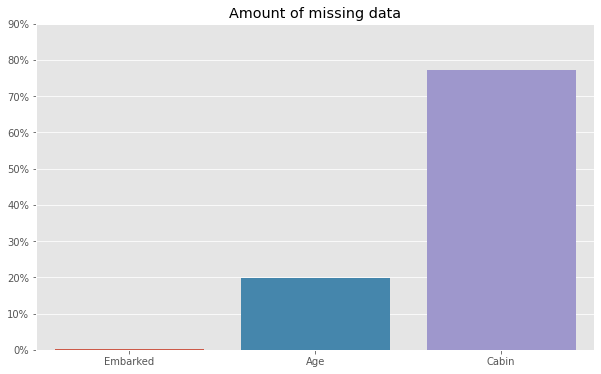

In [23]:

# Get  only columns with missing data
missing_data = (df.isnull().sum() / len(df)) *100
missing_data = missing_data[missing_data > 0].sort_values()
missing_data

# Plot data
g = sns.barplot(x=missing_data.index, y=missing_data.values)
g.set_title('Amount of missing data')

# Replace y-axis labels
replace_labels(g,'%')

### Analysing Survivors

Grouping survivors by class we see that on average 63% of the passengers of the 1st class survived, 47.23% of the 2nd and only 24.24% in the 3rd. This leads us to infer that the social class had influence in the survivors outcome.

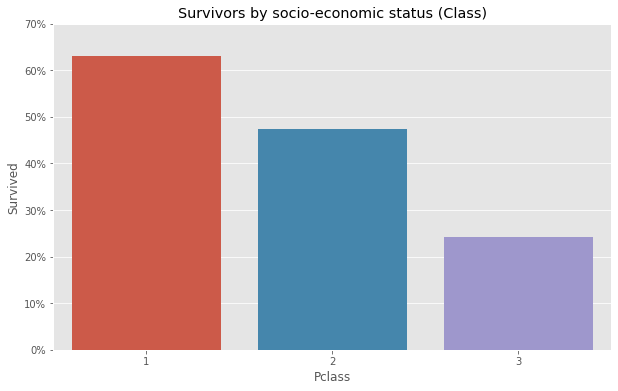

In [24]:

pclass_surv = df[["Survived", "Pclass"]].groupby("Pclass", as_index=False).mean()

g = sns.barplot(x=pclass_surv['Pclass'], y=pclass_surv['Survived']*100)
g.set_title('Survivors by socio-economic status (Class)')

replace_labels(g, '%')


**Not Fair assumptions**


Because we are working on a sample of the population data (all passengers), the assumption above may be not valid for some reasons:

* We don't know if this sample is representative.

* We don't know If it was randomly sampled and if the samples are independent.

So, hypothesis tests can be used to verify the sample data has evidence to accept or reject a hypothesis made about the population, in this case; if are a significant difference between the survivors from the 1st and 3rd class.

&emsp;&emsp;$H_0$: "Nothing special if going on" (The socio-economic status don't affected the survival rate).<br>
&emsp;&emsp;$H_A$: "There's a difference between survivors rate by socio-economic status"

in another words, if:

$p_1$ = proportion of survivors on 1st class and $p_2$ = proportion of survivors on 3rd class<br>
"Nothing unusual is going on" mean $p_1=p_2$ or $p_1 - p_2 = 0$.

&emsp;&emsp;$H_0$: $p_1 - p_2 = 0$<br>
&emsp;&emsp;$H_A$: $p_2 - p_1 \neq 0$

Proportions of two populations are under test, the z-test will be appropriated. The z-test assumes two normally distributed populations, but we don't have the population distribution, only the samples, so the *Central Limit Theorem* can be used. the CLT states that:

> "If you have a population with mean μ and standard deviation σ and take sufficiently large random samples from the population with replacement, then the distribution of the sample means will be approximately normally distributed." [Boston University](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/BS704_Probability12.html#:~:text=The%20central%20limit%20theorem%20states,will%20be%20approximately%20normally%20distributed.)

Then, if we take some subsamples with replacement, the subsamples proportions will follow the normal distribution, then the z-test can be applied.

To decide if the $H_0$ will be accepted or rejected, the p-value of 5% will be used.


In [25]:
contigency_table = pd.crosstab(df['Pclass'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contigency_table)
get_test_result(name="chi-square", score=chi2, p_value=p)

chi-square
Score: 102.89 and p-value: 0.00
H0 can be rejected!


The p-value is smaller than 0.05 which indicates that we can reject $H_0$, and there's a correlation between socio-economic class and survival rate. If the test is repeated using 1st and 2nd class, the same is true.

On average 74% of the women survived against roughly 19% of the men.

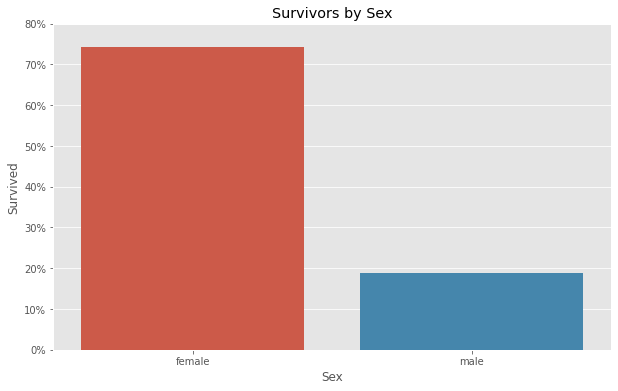

In [ ]:

sex_surv = df[["Survived", "Sex"]].groupby("Sex", as_index=False).mean()
g = sns.barplot(x=sex_surv["Sex"], y=sex_surv["Survived"]*100)
g.set_title('Survivors by Sex')
replace_labels(g, '%')

In [27]:
contigency_table = pd.crosstab(df['Sex'],df['Survived'])
chi2, p, _ , _ = chi2_contingency(contigency_table)
get_test_result(name="chi-square", score=chi2, p_value=p)

chi-square
Score: 260.72 and p-value: 0.00
H0 can be rejected!


People accompanied by spouses, brother, sister, stepbrother, stepsister, or accompanied by at least three relatives had more chance of surviving.

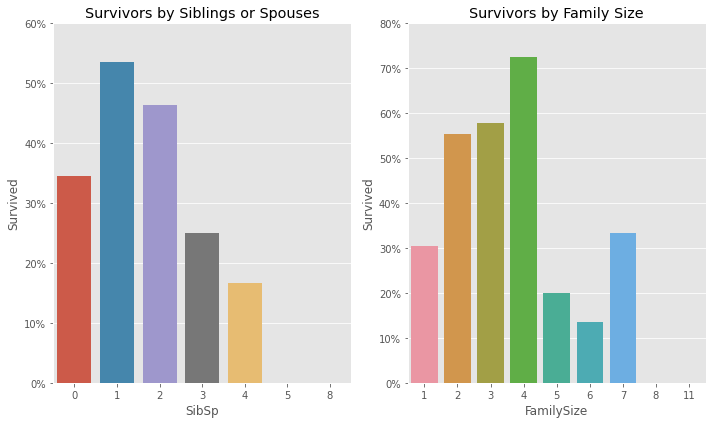

In [ ]:

surv_family = df[["Survived", "SibSp"]].groupby("SibSp", as_index=False).mean()

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
surv_sibsp = df[["Survived", "FamilySize"]].groupby("FamilySize", as_index=False).mean()


_, axs = plt.subplots(1,2)

g0 = sns.barplot(x=surv_family["SibSp"], y=surv_family["Survived"]*100, ax=axs[0])
g0.set_title('Survivors by Siblings or Spouses')
replace_labels(g0, '%')

g1 = sns.barplot(x=surv_sibsp["FamilySize"], y=surv_sibsp["Survived"]*100)
g1.set_title('Survivors by Family Size')
replace_labels(g1, '%')

plt.tight_layout()

Alone people survived less

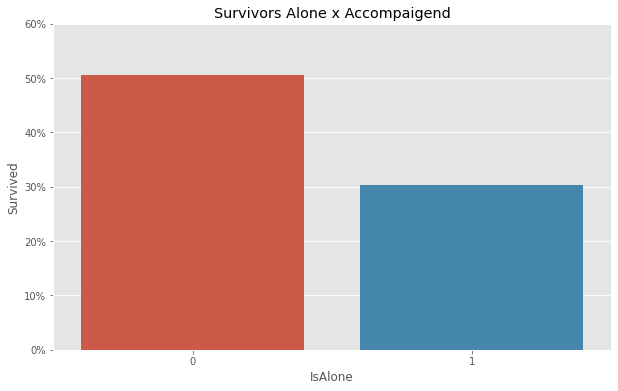

In [ ]:

df["IsAlone"] = 0
df.loc[df["FamilySize"] == 1, "IsAlone"] = 1
surv_alone = df[["Survived", "IsAlone"]].groupby(["IsAlone"], as_index=False).mean()
g = sns.barplot(x=surv_alone["IsAlone"], y=surv_alone["Survived"]*100)
g.set_title("Survivors Alone x Accompaigend")
replace_labels(g, "%")

On average more people who embarked in Cherbourg survived. <br>
(C = Cherbourg, Q = Queenstown, S = Southampton')

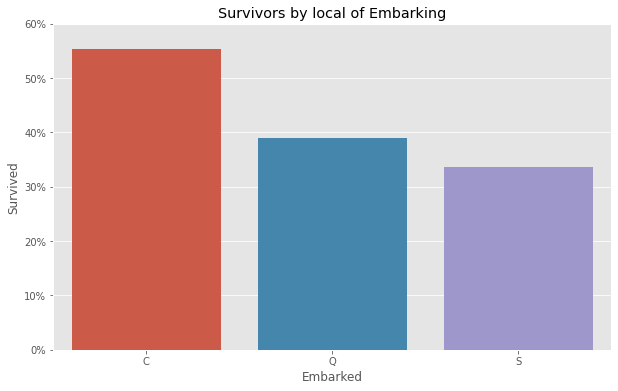

In [ ]:

surv_embarked = df[["Survived", "Embarked"]].groupby("Embarked", as_index=False).mean()
g = sns.barplot(x=surv_embarked["Embarked"], y=surv_embarked["Survived"]*100)
g.set_title('Survivors by local of Embarking')
replace_labels(g, '%')

We can discretize the Fare data into bands, and analyze how the survivors distributed along it

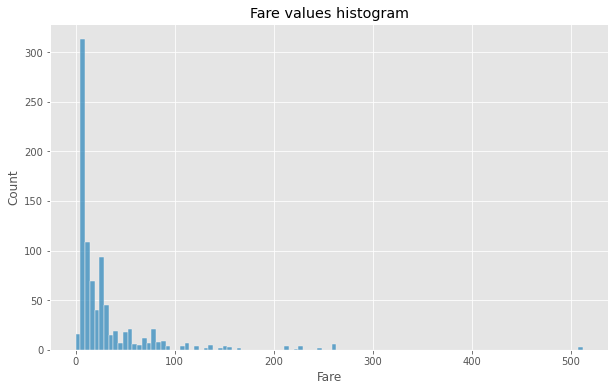

In [ ]:

g = sns.histplot(x=df['Fare'])
_ = g.set_title("Fare values histogram")

In [ ]:
pd.qcut(df['Fare'], 4, precision=2)

0       (-0.01, 7.91]
1      (31.0, 512.33]
2       (7.91, 14.45]
3      (31.0, 512.33]
4       (7.91, 14.45]
            ...      
886     (7.91, 14.45]
887     (14.45, 31.0]
888     (14.45, 31.0]
889     (14.45, 31.0]
890     (-0.01, 7.91]
Name: Fare, Length: 891, dtype: category
Categories (4, interval[float64, right]): [(-0.01, 7.91] < (7.91, 14.45] < (14.45, 31.0] < (31.0, 512.33]]

Rich people, as also shown by Pclass plot, have survived more.

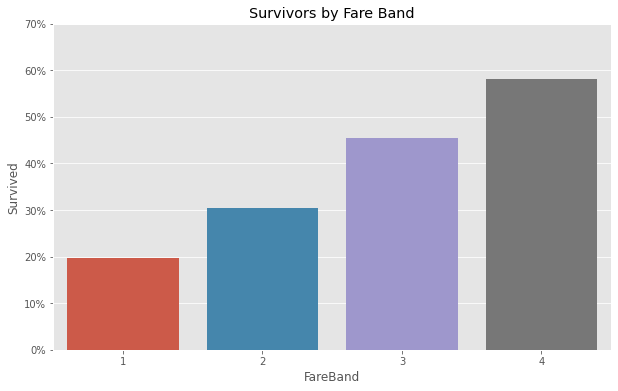

In [ ]:

df['FareBand'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])
surv_fare = df[["Survived", "FareBand"]].groupby("FareBand", as_index=False).mean()
g = sns.barplot(x=surv_fare["FareBand"], y=surv_fare["Survived"]*100)
g.set_title('Survivors by Fare Band')
replace_labels(g, '%')

Before analyzing the ages, we need to fill in a few missing values. If the data followed the normal distribution, the mean would be a good guess, but this is not the case, as you can see by the Anderson test result.

In [ ]:
print("Null hypothesis (H0): Age follows the normal curve")
perfom_anderson_test(df['Age'].dropna())


Null hypothesis (H0): Age follows the normal curve
Statistic = 3.82
significance level = 15.00, critical value = 0.57, (reject H0)
significance level = 10.00, critical value = 0.65, (reject H0)
significance level = 5.00, critical value = 0.78, (reject H0)
significance level = 2.50, critical value = 0.91, (reject H0)
significance level = 1.00, critical value = 1.09, (reject H0)




So, i will use the KKNinputer to fill data.

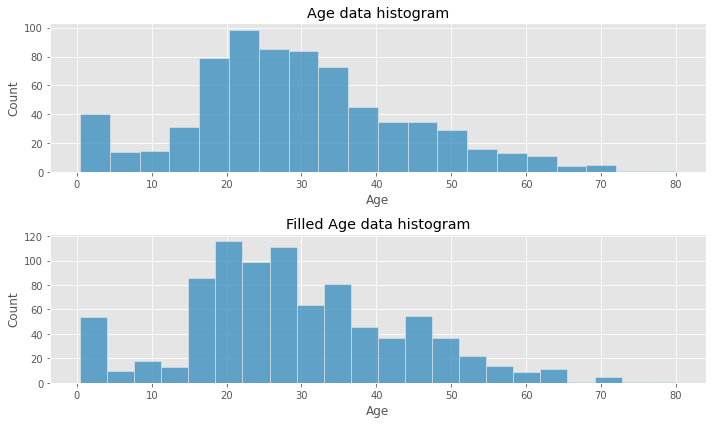

In [ ]:

_, ax = plt.subplots(2,1)

# Save the old value of Age data
old_data =  df['Age']

# Encode string as numeric values
enc = OrdinalEncoder()
df[['Sex','Embarked']] = enc.fit_transform(df[['Sex','Embarked']])

# Input data based on KNN
imputer = KNNImputer(n_neighbors=2)
df[['Pclass','Sex','Age','FareBand','Embarked']]= imputer.fit_transform(df[['Pclass','Sex','Age','FareBand','Embarked']])

# Restore data labels
df[['Sex','Embarked']] = enc.inverse_transform(df[['Sex', 'Embarked']])

g0 = sns.histplot(old_data, ax=ax[0])
_ = g0.set_title('Age data histogram')

g1 = sns.histplot(df['Age'], ax=ax[1])
_ = g1.set_title('Filled Age data histogram')

plt.tight_layout()

Children and Youth survived more, analyzing by the sex, this difference is bigger as higher age

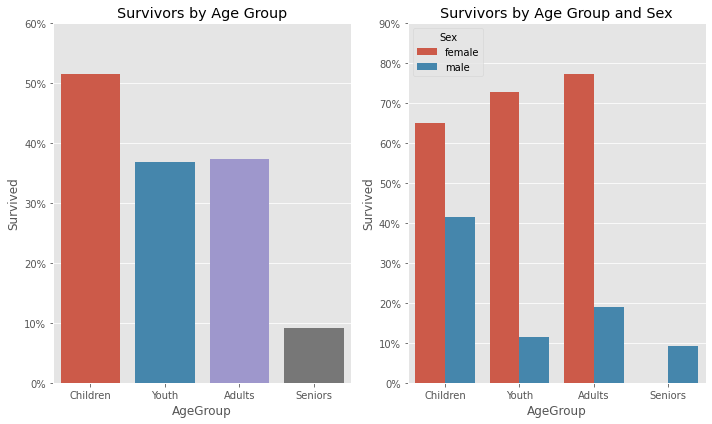

In [ ]:

_, ax= plt.subplots(1,2)

df['AgeGroup'] = pd.cut(df['Age'], [0,14,24,64, 150], labels=['Children','Youth','Adults','Seniors'])

surv_agegroup = df[["Survived", "AgeGroup"]].groupby(["AgeGroup"], as_index=False).mean()
surv_agegroup['Survived'] *= 100

surv_agegroup_sex = df[["Survived","Sex", "AgeGroup"]].groupby(["AgeGroup","Sex"], as_index=False).mean()
surv_agegroup_sex['Survived'] *= 100


g0 = sns.barplot(data=surv_agegroup, x="AgeGroup", y="Survived", ax=ax[0])

g1 = sns.barplot(data=surv_agegroup_sex, x="AgeGroup", y="Survived", hue="Sex", ax=ax[1])

_ = g0.set_title('Survivors by Age Group')
replace_labels(g0, '%')

_ = g1.set_title('Survivors by Age Group and Sex')
replace_labels(g1, '%')

plt.tight_layout()

By analyzing the name, we can extract the title. Below you can see the passenges of the Titanic by their titles.

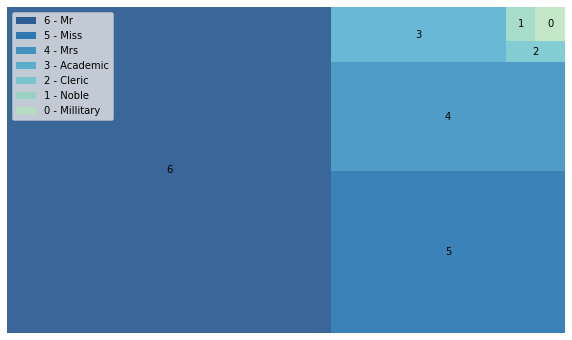

In [ ]:

# Extract only title from the name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace titles
df['Title'] = df['Title'].replace(['Rev'], 'Cleric')
df['Title'] = df['Title'].replace(['Don', 'Countess', 'Sir', 'Lady', 'Jonkheer'], 'Noble')
df['Title'] = df['Title'].replace(['Col', 'Capt','Major'], 'Millitary')
df['Title'] = df['Title'].replace(['Mlle','Mme', 'Ms'],'Miss')
df['Title'] = df['Title'].replace(['Master','Dr'],'Academic')

# Plot
colors = cm.GnBu_r(np.linspace(0, 1, 10))
titles = df['Title'].value_counts()
ax = squarify.plot(sizes=titles.values, label=[6,5,4,3,2,1,0], alpha=.8, color=colors)
labels = ['6 - Mr', '5 - Miss', '4 - Mrs', '3 - Academic', '2 - Cleric', '1 - Noble', '0 - Millitary']
_ = plt.legend(handles=ax.containers[0], labels=labels)
_ = plt.axis('off')

People will have high titles and Women regardless of their titles have survived more. None of the Clerics has survived.

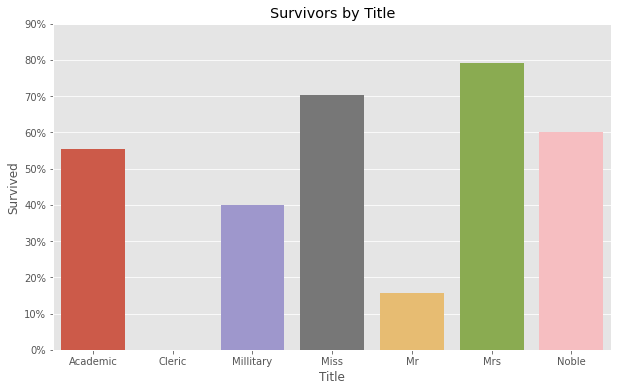

In [ ]:

surv_title = df[["Survived", "Title"]].groupby(["Title"], as_index=False).mean()
g = sns.barplot(x=surv_title["Title"], y=surv_title["Survived"]*100)
_ = g.set_title("Survivors by Title")
replace_labels(g, '%')
